# Sweep regions

Extract swept regions around peaks

In [50]:
import re, os, sys, pickle, pickle, subprocess, bisect, random
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series

import scipy

from ete3 import Tree
from scipy.cluster.hierarchy import dendrogram, linkage

import pyfaidx

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)
random.seed(7)

In [51]:
import re, os, sys, pickle, math, collections, random
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame
from ete3 import Tree
from scipy.cluster.hierarchy import dendrogram, linkage
import subprocess
import bisect
import pyfaidx

Plotting setup:

In [52]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [53]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### Analysis dirs

In [54]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

reference_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Href.fa')

Import variables global to the entire analysis:

In [55]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [56]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [57]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def flatten_column_index(df):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]


In [58]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Load meta data

In [59]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load sweep data

In [60]:
non_afr_total_swept = pandas.read_hdf(results_dir / 'non_afr_total_swept.hdf')
afr_total_swept = pandas.read_hdf(results_dir / 'afr_total_swept.hdf')
sweep_peaks = pandas.read_hdf(results_dir / 'sweep_peaks.hdf')
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

In [61]:
sweep_peaks.head()

,start,end,prop_swept,pos
run_id,,,,
1,11200000,11600000,0.364286,11400000.0
3,14700000,14800000,0.464286,14750000.0
5,19800000,19900000,0.835714,19850000.0
6,21100000,21300000,0.828571,21200000.0
7,36200000,36300000,0.700000,36250000.0


In [62]:
non_afr_total_swept.head()

,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,1,2700000,2800000,True,0.0,139,2750000.0,0.0
1,3,2800000,2900000,True,0.0,140,2850000.0,0.0
2,5,2900000,3000000,True,0.0,140,2950000.0,0.0
3,7,3000000,3100000,True,0.0,140,3050000.0,0.0
4,9,3100000,3200000,True,0.0,140,3150000.0,0.0


Make sure the index is 0, 1, 2 ...

In [63]:
non_afr_total_swept.reset_index(drop=True, inplace=True)
print(len(non_afr_total_swept))
non_afr_total_swept.tail()

1385


,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
1380,2760,154100000,154200000,True,63.0,140,154150000.0,0.450000
1381,2762,154200000,154300000,True,66.0,140,154250000.0,0.471429
1382,2764,154300000,154400000,True,64.0,140,154350000.0,0.457143
1383,2766,154400000,154500000,True,71.0,140,154450000.0,0.507143
1384,2768,154800000,154900000,True,71.0,140,154850000.0,0.507143


For each peak find a region around the peak that spans 1Mb and includes as many individuals as possible.

In [68]:
def get_extended_region(df, peak_pos, max_width, min_sub_prop):
    
    peak_idx = non_afr_total_swept.loc[lambda df: (df.start <= peak_pos) & (df.end > peak_pos)].index[0]
    start_idx, end_idx = peak_idx, peak_idx
    peak_prop_swept = df.prop_swept[start_idx]
    cutoff = peak_prop_swept
    prev_cutoff = peak_prop_swept
    while df.end[end_idx] - df.start[start_idx] < max_width:
    
        if start_idx-2 < 0 or end_idx+2 >= len(df.end):
            break
    
        # if largest of left and right falls below cutoff we break:
        if max(df.prop_swept[start_idx-1], df.prop_swept[end_idx+1]) <= peak_prop_swept * min_sub_prop:
            # we still want this to represent the peak
            break
        
        # extend to the left:
        if df.prop_swept[start_idx-1] > df.prop_swept[end_idx+1]:
            cutoff = df.prop_swept[start_idx-1]
#             if cutoff > prev_cutoff: # if cutoff incease we are overlapping a different sweep
            if cutoff > prev_cutoff and df.prop_swept[start_idx-2] > prev_cutoff: # if cutoff incease we are overlapping a different sweep
                break
            start_idx -= 1
        # extend to the right:
        else:
            cutoff = df.prop_swept[end_idx+1]
#             if cutoff > prev_cutoff: # if cutoff incease we are overlapping a different sweep
            if cutoff > prev_cutoff and df.prop_swept[end_idx+2] > prev_cutoff:
                break
            end_idx += 1

        prev_cutoff = cutoff
            
    return df.start[start_idx], df.end[end_idx], prev_cutoff

## Get the extended regions around peaks

Extract the region around each peak where some percentage of the peak prop_swept is included.

**Note:** in the dataframes for such regions `prop_swept` does *not* refer to the peak but to a minimum proportion of individuals swept across the region.

In [69]:
for min_sub_prop in [0.1, 0.75, 0.9]:

    extended_regions = list()

    for tup in sweep_peaks.itertuples():

        # get extended region
        start_pos, end_pos, prop_swept = get_extended_region(non_afr_total_swept, tup.pos, 1e9, min_sub_prop)
        
        # get the relevant windows of the chromosome
        df = sweep_data.loc[lambda df: (df.start >= start_pos) & \
                            (df.end <= end_pos) & \
                            (df.swept)]

        # get swept the relevant windows of the chromosome: 
        # get only windows from individuals that are swept across the entire region
        df = df.groupby('indiv_1').filter(lambda df: len(df.index) == (end_pos - start_pos)/100000)

        # get the individuals
        swept_indivs = df.indiv_1.unique().tolist()

        # sanity check
        expected = len(swept_indivs)*(end_pos - start_pos)/100000
        assert expected == len(df.index)
        
        extended_regions.append((tup.pos, tup.start, tup.end, tup.prop_swept, start_pos, end_pos, prop_swept, swept_indivs))

        
    extended_peak_regions = DataFrame().from_records(extended_regions, 
                                   columns=['pos', 'peak_start', 'peak_end', 'peak_prop_swept', 'start_pos', 'end_pos', 
                                            'prop_swept', 'swept_indivs'])

    extended_peak_regions.swept_indivs = [repr(x) for x in extended_peak_regions.swept_indivs]
    extended_peak_regions.to_hdf(results_dir / 'extended_peak_regions_{:.0f}%.hdf'.format(min_sub_prop*100), 'df', format='table', mode='w')



Write one of the sets of extended regions to pickle file for using for dating them:

In [70]:
extended_peak_regions_10 = pandas.read_hdf(results_dir / 'extended_peak_regions_10%.hdf')
(extended_peak_regions_10
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / 'extended_peak_regions_10%.csv', index=False)
)
extended_peak_regions_75 = pandas.read_hdf(results_dir / 'extended_peak_regions_75%.hdf')
(extended_peak_regions_75
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / 'extended_peak_regions_75%.csv', index=False)
)
extended_peak_regions_90 = pandas.read_hdf(results_dir / 'extended_peak_regions_90%.hdf')
(extended_peak_regions_90
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / 'extended_peak_regions_90%.csv', index=False)
)

In [71]:
"Total 90% region", extended_peak_regions_90.assign(length = lambda df: df.end_pos-df.start_pos).length.sum()

('Total 90% region', 12100000)

In [72]:
"Total 75% region", extended_peak_regions_75.assign(length = lambda df: df.end_pos-df.start_pos).length.sum()

('Total 75% region', 18100000)

In [73]:
10700000 / 155270560

0.06891196888837137

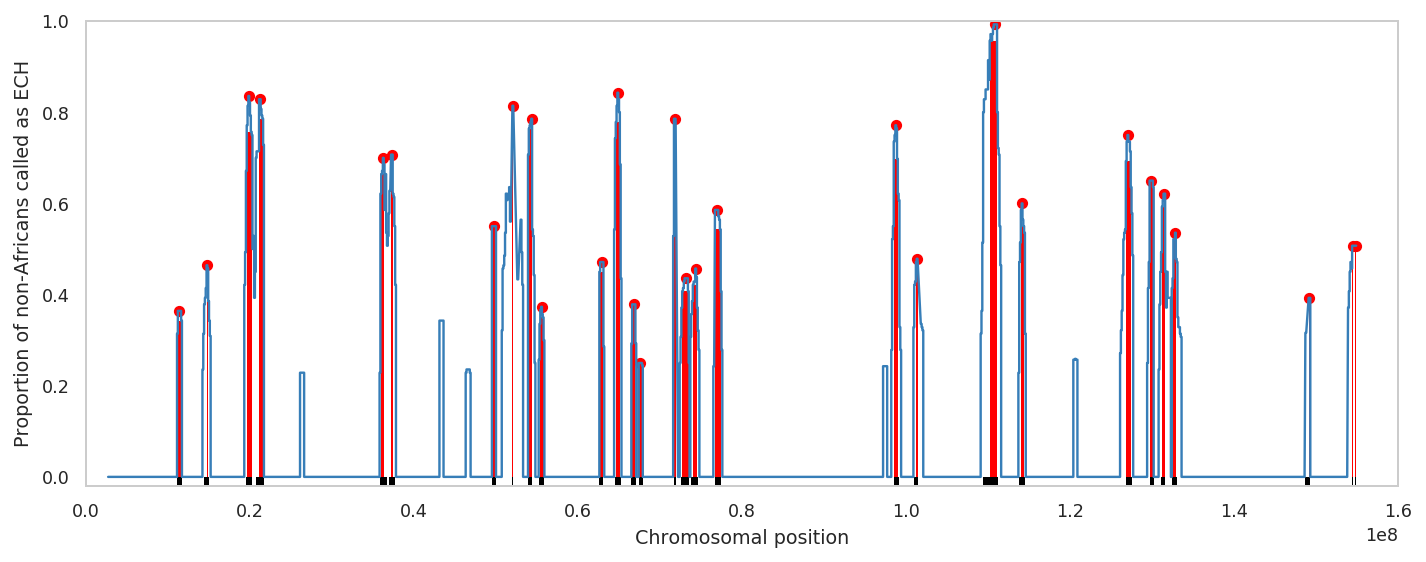

In [74]:
with sns.color_palette([set1['blue']]):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y)
        g = ax.scatter(sweep_peaks.pos, sweep_peaks.prop_swept, c='red')

        for tup in extended_peak_regions_90.itertuples():
            g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, tup.prop_swept, 
                         facecolor='red',
                         linewidth=0,
                         alpha=1.0,
                         zorder=1))

        for tup in extended_peak_regions_75.itertuples():
            g = ax.add_patch(Rectangle((tup.start_pos, -0.02), tup.end_pos-tup.start_pos, 0.02, 
                         facecolor='black',
                         linewidth=0,
                         alpha=1.0,
                         zorder=1))
            
        ax.set_ylim(-0.02,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / 'tot_swept_ext_regions.pdf')) 
        
#mpld3.display(fig)

In [75]:
(extended_peak_regions_90
 .assign(prop_swept_across=lambda df: [len(eval(x))/140 for x in df.swept_indivs])
 .assign(length=lambda df: df.end_pos-df.start_pos)
 .drop('swept_indivs', axis=1)
 .sort_values('length', ascending=False)
)

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,prop_swept_across,length
20,110900000.0,110700000,111100000,0.992857,110200000,111100000,0.957143,0.921429,900000
15,73200000.0,73000000,73400000,0.435714,72700000,73500000,0.407143,0.378571,800000
17,76900000.0,76700000,77100000,0.585714,76700000,77400000,0.542857,0.542857,700000
22,127050000.0,127000000,127100000,0.750000,126800000,127400000,0.692857,0.607143,600000
2,19850000.0,19800000,19900000,0.835714,19600000,20200000,0.757143,0.671429,600000
0,11400000.0,11200000,11600000,0.364286,11200000,11700000,0.342857,0.342857,500000
23,129900000.0,129700000,130100000,0.650000,129700000,130200000,0.635714,0.642857,500000
18,98750000.0,98700000,98800000,0.771429,98500000,99000000,0.697842,0.642857,500000
16,74350000.0,74300000,74400000,0.457143,74000000,74500000,0.421429,0.400000,500000
13,67600000.0,67400000,67800000,0.250000,67400000,67900000,0.244604,0.250000,500000


In [76]:
(extended_peak_regions_75
 .assign(prop_swept_across=lambda df: [len(eval(x))/140 for x in df.swept_indivs])
 .assign(length=lambda df: df.end_pos-df.start_pos)
 .drop('swept_indivs', axis=1)
 .sort_values('length', ascending=False)
)

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,prop_swept_across,length
20,110900000.0,110700000,111100000,0.992857,109400000,111200000,0.800000,0.550000,1800000
3,21200000.0,21100000,21300000,0.828571,20700000,21700000,0.700000,0.571429,1000000
15,73200000.0,73000000,73400000,0.435714,72600000,73500000,0.371429,0.342857,900000
2,19850000.0,19800000,19900000,0.835714,19500000,20300000,0.671429,0.564286,800000
4,36250000.0,36200000,36300000,0.700000,35900000,36700000,0.535714,0.342857,800000
5,37300000.0,37200000,37400000,0.707143,36900000,37700000,0.550000,0.414286,800000
22,127050000.0,127000000,127100000,0.750000,126800000,127600000,0.578571,0.485714,800000
16,74350000.0,74300000,74400000,0.457143,73800000,74600000,0.357143,0.300000,800000
21,114150000.0,114100000,114200000,0.600000,113800000,114500000,0.471429,0.407143,700000
18,98750000.0,98700000,98800000,0.771429,98500000,99200000,0.607143,0.550000,700000


In [77]:
(extended_peak_regions_10
 .assign(prop_swept_across=lambda df: [len(eval(x))/140 for x in df.swept_indivs])
 .assign(length=lambda df: df.end_pos-df.start_pos)
 .drop('swept_indivs', axis=1)
 .sort_values('length', ascending=False)
)

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,prop_swept_across,length
20,110900000.0,110700000,111100000,0.992857,109100000,111600000,0.314286,0.185714,2500000
22,127050000.0,127000000,127100000,0.750000,126100000,127700000,0.271429,0.121429,1600000
2,19850000.0,19800000,19900000,0.835714,19300000,20600000,0.392857,0.057143,1300000
25,132850000.0,132800000,132900000,0.535714,132400000,133600000,0.307143,0.142857,1200000
19,101350000.0,101300000,101400000,0.478571,100900000,102100000,0.321429,0.200000,1200000
15,73200000.0,73000000,73400000,0.435714,72400000,73600000,0.250000,0.121429,1200000
18,98750000.0,98700000,98800000,0.771429,98200000,99400000,0.278571,0.085714,1200000
3,21200000.0,21100000,21300000,0.828571,20500000,21700000,0.392857,0.314286,1200000
16,74350000.0,74300000,74400000,0.457143,73700000,74800000,0.278571,0.171429,1100000
17,76900000.0,76700000,77100000,0.585714,76500000,77600000,0.242857,0.135714,1100000


In [78]:
extended_peak_regions_10 = pandas.read_hdf(results_dir / 'extended_peak_regions_10%.hdf')
(extended_peak_regions_10
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / 'extended_peak_regions_10%.csv', index=False)
)

In [79]:
renaming = {'peak_start': 'peak start', 'peak_prop_swept': 'peak prop swept', 'peak_end': 'peak end',
            'start_pos': 'start', 'end_pos': 'end', 
            'prop_swept': 'Min freq. ECH', 'prop_swept_across': 'Freq. ECHs spanning region'}

df = ((extended_peak_regions_75 
       .assign(prop_swept=lambda df: df.prop_swept.round(2),
               prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
               length=lambda df: df.end_pos - df.start_pos)
       .drop(['pos', 'swept_indivs'], axis=1)
      ).rename(columns=renaming)
      .merge((extended_peak_regions_90
             .assign(prop_swept=lambda df: df.prop_swept.round(2),
                     prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
                     length=lambda df: df.end_pos - df.start_pos)
              .drop(['pos', 'swept_indivs'], axis=1)
             ).rename(columns=renaming), 
             on=['peak start', 'peak end', 'peak prop swept'],
             suffixes=(' (75%)', ' (90%)'))
     .sort_values(by='peak start')
     )

#df.to_csv(results_dir / 'ech_regions_som.csv', index=False)
df

,peak start,peak end,peak prop swept,start (75%),end (75%),Min freq. ECH (75%),Freq. ECHs spanning region (75%),length (75%),start (90%),end (90%),Min freq. ECH (90%),Freq. ECHs spanning region (90%),length (90%)
0,11200000,11600000,0.364286,11100000,11700000,0.31,0.29,600000,11200000,11700000,0.34,0.34,500000
1,14700000,14800000,0.464286,14400000,15000000,0.38,0.29,600000,14700000,14900000,0.46,0.46,200000
2,19800000,19900000,0.835714,19500000,20300000,0.67,0.56,800000,19600000,20200000,0.76,0.67,600000
3,21100000,21300000,0.828571,20700000,21700000,0.70,0.57,1000000,21100000,21600000,0.79,0.76,500000
4,36200000,36300000,0.700000,35900000,36700000,0.54,0.34,800000,36000000,36400000,0.66,0.65,400000
5,37200000,37400000,0.707143,36900000,37700000,0.55,0.41,800000,37200000,37400000,0.71,0.70,200000
6,49500000,50000000,0.550000,49500000,50000000,0.55,0.55,500000,49500000,50000000,0.55,0.55,500000
7,52000000,52100000,0.814286,52000000,52100000,0.81,0.82,100000,52000000,52100000,0.81,0.82,100000
8,54300000,54400000,0.785714,53900000,54400000,0.71,0.71,500000,54000000,54400000,0.76,0.76,400000
9,55500000,55600000,0.373134,55300000,55900000,0.30,0.28,600000,55400000,55800000,0.35,0.35,400000


## Table for supplementary

In [80]:
df = (((sweep_peaks[['pos', 'start', 'end', 'prop_swept']]
        .merge(extended_peak_regions_90, suffixes=('_peak', ''), 
               left_on=['pos', 'start', 'end'], right_on=['pos', 'peak_start', 'peak_end'])
       ).drop(['start', 'end'], axis=1)
        .assign(prop_swept_peak=lambda df: [round(x, 2) for x in df.prop_swept_peak] )

       .assign(prop_swept=lambda df: df.prop_swept.round(2),
               prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
               peak_start = lambda df: (df.peak_start / 100000).astype('int'),
               peak_end = lambda df: (df.peak_end / 100000).astype('int'),
               start_pos=lambda df: (df.start_pos / 100000).astype('int'),
               end_pos=lambda df: (df.end_pos / 100000).astype('int'))
       .assign(length=lambda df: df.end_pos - df.start_pos)
       .drop(['swept_indivs'], axis=1)
      )[['pos', 'peak_start', 'peak_end', 'prop_swept_peak', 'start_pos', 'end_pos', 'length', 'prop_swept', 'prop_swept_across']]
      .merge((extended_peak_regions_75
             .assign(prop_swept=lambda df: df.prop_swept.round(2),
                     prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
                     peak_start = lambda df: (df.peak_start / 100000).astype('int'),
                     peak_end = lambda df: (df.peak_end / 100000).astype('int'),
                     start_pos=lambda df: (df.start_pos / 100000).astype('int'),
                     end_pos=lambda df: (df.end_pos / 100000).astype('int'))
              .assign(length=lambda df: df.end_pos - df.start_pos)
              .drop(['swept_indivs'], axis=1)
             )[['pos', 'peak_start', 'peak_end', 'start_pos', 'end_pos', 'length', 'prop_swept', 'prop_swept_across']], 
             on=['pos', 'peak_start', 'peak_end'],
             suffixes=(' (90%)', ' (75%)'))
     .sort_values(by=['peak_start'])
     )

df.columns = pandas.MultiIndex(levels=[['Peak', '90%-region', '75%-region'], 
                                       ['pos', 'Start', 'End', 'Freq. ECH', 'Length', 'Min freq. ECH', 'Freq. ECHs spanning region']], 
                               labels=[[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], 
                                       [0, 1, 2, 3, 1, 2, 4, 5, 6, 1, 2, 4, 5, 6]])
df = df.drop(('Peak', 'pos'), axis=1)

df[('Data S1', 'Subplot')] = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ$%&#@*'[:len(df)])

df.to_csv(results_dir / 'ech_regions_som_multidx.csv', index=False)
df

Peak                 90%-region                             \
   Start   End Freq. ECH      Start   End Length Min freq. ECH   
0    112   116      0.36        112   117      5          0.34   
1    147   148      0.46        147   149      2          0.46   
2    198   199      0.84        196   202      6          0.76   
3    211   213      0.83        211   216      5          0.79   
4    362   363      0.70        360   364      4          0.66   
5    372   374      0.71        372   374      2          0.71   
6    495   500      0.55        495   500      5          0.55   
7    520   521      0.81        520   521      1          0.81   
8    543   544      0.79        540   544      4          0.76   
9    555   556      0.37        554   558      4          0.35   
10   627   631      0.47        626   631      5          0.45   
11   648   649      0.84        646   651      5          0.78   
12   666   670      0.38        666   670      4          0.38   
13   674   678      0.25        674   679      5          0.24   
14   717   719      0.79        717   719      2          0.79   
15   730   734      0.44        727   735      8          0.41   
16   743   744      0.46        740   745      5          0.42   
17   767   771      0.59        767   774      7          0.54   
18   987   988      0.77        985   990      5          0.70   
19  1013  1014      0.48       1012  1014      2          0.47   
20  1107  1111      0.99       1102  1111      9          0.96   
21  1141  1142      0.60       1140  1144      4          0.55   
22  1270  1271      0.75       1268  1274      6          0.69   
23  1297  1301      0.65       1297  1302      5          0.64   
24  1314  1316      0.62       1312  1316      4          0.59   
25  1328  1329      0.54       1326  1329      3          0.52   
26  1491  1493      0.39       1491  1493      2          0.39   
27  1544  1545      0.51       1544  1545      1          0.51   
28  1548  1549      0.51       1548  1549      1          0.51   

                              75%-region                             \
   Freq. ECHs spanning region      Start   End Length Min freq. ECH   
0                        0.34        111   117      6          0.31   
1                        0.46        144   150      6          0.38   
2                        0.67        195   203      8          0.67   
3                        0.76        207   217     10          0.70   
4                        0.65        359   367      8          0.54   
5                        0.70        369   377      8          0.55   
6                        0.55        495   500      5          0.55   
7                        0.82        520   521      1          0.81   
8                        0.76        539   544      5          0.71   
9                        0.35        553   559      6          0.30   
10                       0.45        626   631      5          0.45   
11                       0.74        645   652      7          0.69   
12                       0.38        665   671      6          0.29   
13                       0.25        674   679      5          0.24   
14                       0.79        717   719      2          0.79   
15                       0.38        726   735      9          0.37   
16                       0.40        738   746      8          0.36   
17                       0.54        767   774      7          0.54   
18                       0.64        985   992      7          0.61   
19                       0.47       1010  1014      4          0.42   
20                       0.92       1094  1112     18          0.80   
21                       0.54       1138  1145      7          0.47   
22                       0.61       1268  1276      8          0.58   
23                       0.64       1297  1302      5          0.64   
24                       0.59       1311  1316      5          0.49   
25                       0.52       1324

## relative TMRCA_half in extended regions

We use the 90% set for this and only regions with enough individuals swept that we call them as sweeps.


In [ ]:
tmrca_stats_world = pandas.read_hdf(results_dir / 'pruned_tmrca_stats.hdf')
tmrca_stats_world.head()

In [ ]:
extended_peak_regions_90.loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept]

In [ ]:
global_mean = tmrca_stats_world.rel_tmrca_half.mean()
print('global mean rel_tmrca_half:', global_mean)

In [ ]:
def get_rel_tmrca_half(df):
    s, e = df.start_pos.iloc[0], df.end_pos.iloc[0]
    return tmrca_stats_world.loc[lambda df: (df.start >= s) & (df.end <= e)]

In [ ]:
sr = (extended_peak_regions_90.loc[lambda df: df.prop_swept >= 0.25]
           .groupby(['pos', 'prop_swept']).apply(get_rel_tmrca_half).reset_index()
          )['rel_tmrca_half']
print('mean rel_tmrca_half for all sweeps:', sr.mean())
print(scipy.stats.ttest_ind(tmrca_stats_world.rel_tmrca_half, sr))

In [ ]:
sr = (extended_peak_regions_90.loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept]
           .groupby(['pos', 'prop_swept']).apply(get_rel_tmrca_half).reset_index()
          )['rel_tmrca_half']
print('mean rel_tmrca_half for all sweeps:', sr.mean())
print(scipy.stats.ttest_ind(tmrca_stats_world.rel_tmrca_half, sr))

## Extract SNPs shared by all swept individuals (for David)

We use the 90% set for this and only regions with enough individuals swept that we call them as sweeps.

We extract window for all non-Africans and get all positions segregating in non-Africans that are fixed in the swept non-African individuals. We discard positions with more than one base, with less than half of all bases called or with less than half of bases called in swept individuals.

Load sequence indexes:

In [ ]:
file_index = dict()
for file_path in male_x_haploid_dir.glob('*.fa'):
    name = file_path.name.split('.')[0]
    file_index[name] = pyfaidx.Fasta(str(file_path), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)
    
reference_index = pyfaidx.Fasta(str(reference_genome_file), 
                                 strict_bounds=True, 
                                 one_based_attributes=False)
    
def get_alignmnet(sample_ids, start, end):
    assert start < end
    start, end = int(start), int(end)
    seq_list = list()
    name_list = list()

    for sample_id in sample_ids:
        name = sample_id + '-A'   
        seq_list.append(file_index[name]['X'][start:end].seq)
        name_list.append(name.replace('-A', ''))
        
    return name_list, seq_list

In [ ]:
from collections import Counter

non_afr_indivs = sweep_data.loc[lambda df: df.region_1 != 'Africa', 'indiv_1'].unique()

records = list()
for tup in extended_peak_regions_90.loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept].itertuples():

    pos, start, end = tup.pos, tup.peak_start, tup.peak_end

    # sequenes in window
    names, aln = get_alignmnet(non_afr_indivs, start, end)    

    # reference sequence
    ref = reference_index['X'][start:end].seq
    
    # get snp columns
    snp_idx = dict()
    for j in range(end-start):
        col = [aln[i][j] for i in range(len(aln))]

        if col.count('N') / len(non_afr_indivs) > 0.5:
            continue

        counter = Counter(col)

        if 'N' in counter:
            del counter['N']

        counts = counter.most_common()
        if len(counts) == 2:
            snp_idx[j] = counter

    # get snps that are fixed in swept indivs
    swept_indivs = eval(tup.swept_indivs)
    subaln = [seq for (name, seq) in zip(names, aln) if name in swept_indivs]
    for j, counter in snp_idx.items():
        try:
            col = [subaln[i][j] for i in range(len(subaln))]
        except IndexError:
            print(j, len(subaln), len(swept_indivs))
            print(names)
            print(swept_indivs)
            print
            raise

        if col.count('N') / len(swept_indivs) > 0.5:
            continue

        bases = set(col)
        if 'N' in bases:
            bases.remove('N')
        if len(bases) == 1:
            swept_base = bases.pop()
            alt_base = [b for b in counter if b != swept_base][0]
            ref_base = ref[j]            
            records.append((pos, start, end,
                  j+start,
                  swept_base, counter[swept_base], 
                  alt_base, counter[alt_base], 
                  ref_base, 
                  len(swept_indivs), len(non_afr_indivs), repr(swept_indivs)))
        
snps_for_david = pandas.DataFrame().from_records(records, columns=['peak_pos', 'start', 'end', 'snp_pos', 
                                                  'swept_base', 'swept_base_count', 'other_base', 'other_base_count', 
                                                  'ref_base', 'nr_swept_indiv', 'nr_non_afr_indiv', 'swept_indivs'])

In [ ]:
snps_for_david.to_hdf(results_dir / 'snps_for_david.hdf', 'df', format='table', mode='w')
snps_for_david.to_csv(results_dir / 'snps_for_david.tsv', sep='\t')